In [145]:
import pandas as pd
import numpy as np
import scipy.linalg as sla
import scipy.sparse.linalg as ssla

import matplotlib.pyplot as plt
import seaborn as sns
from src.data_gen import data_gen

# Set the global font to be Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 8 
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [146]:
# matrix left/right division (following MATLAB function naming)
_mldivide = lambda denom, numer: sla.lstsq(np.array(denom), np.array(numer))[0]
_mrdivide = lambda numer, denom: (sla.lstsq(np.array(denom).T, np.array(numer).T)[0]).T

### 1. Generate the data

In [147]:
# number of time periods and individuals
T0, T1 = 20, 10
N_co, N_tr = 45, 5

# number of covariates and time-varying factors
L, K = 10, 2
# drift
drift = 2

np.random.seed(2)
df = data_gen(T0=T0, T1=T1, N_co=N_co, N_tr=N_tr, L=L, K=K, drift=drift)
# add a const to the original data
df['const'] = 1

### 2. Generate the data under the null

In [148]:
# define a function to generate the null
def under_null(df, null, treated):
    data = df.copy()
    y = np.where(data[treated]==1, data['y'] - null, data['y'])
    return data.assign(**{'y': y})

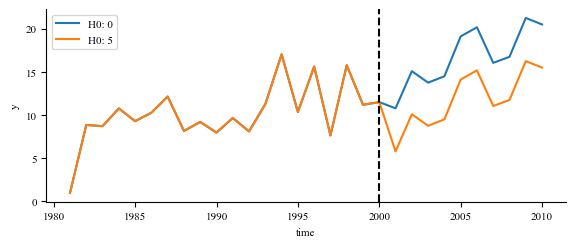

In [149]:
# under the null = 0
null_0 = under_null(df, 0, 'treated')
# under the null = 5
null_5 = under_null(df, 5, 'treated')

plt.figure(figsize=(6.7, 2.5))
# plot the generated data under different null hypothesis
sns.lineplot(null_0.query("tr_group==1").groupby('time').y.mean(), label='H0: 0')
sns.lineplot(null_5.query("tr_group==1").groupby('time').y.mean(), label='H0: 5')

plt.axvline(x=df.query("post_period==0").time.max(), linestyle='--', color='black')
sns.despine()

### 3. Fit the model use contorl data

In [150]:
# define a function to transform matrix
def _prepare_matrix(df, covariates):
    Y = df.pivot(index='id', columns='time', values='y').values
    X = np.array([df.pivot(index='id', columns='time', values=x) for x in covariates]).transpose(1, 2, 0)
    return Y, X

In [151]:
# add constant
null_5['const'] = 1
# gen covariates
covariates = ['const'] + [f'x{i+1}' for i in range(L)]

# use all the data to compute F and Gama
Y, X = _prepare_matrix(null_5, covariates)

In [152]:
# define a function to conduct ALS estimation
def als_est(X, Y, K, F0):
    N, T, L = X.shape
    # with F fixed, estimate Gama
    vec_len = L*K
    numer, denom = np.zeros(vec_len), np.zeros((vec_len, vec_len))
    for t in range(T):
        for i in range(N):
            # slice X and F
            X_slice = X[i, t, :]
            F_slice = F0[:, t]
            # compute kronecker product
            kron_prod = np.kron(X_slice, F_slice)
            # update numer and denom
            numer += kron_prod * Y[i, t]
            denom += np.outer(kron_prod, kron_prod)
    # solve for Gama
    Gama1 = _mldivide(denom, numer).reshape(L, K)

    # with Gama fixed, estimate F
    F1 = np.zeros((K, T))
    for t in range(T):
        denom = Gama1.T@X[:,t,:].T@X[:,t,:]@Gama1
        numer = Gama1.T@X[:,t,:].T@Y[:,t]
        F1[:, t] = _mldivide(denom, numer)
    return Gama1, F1

In [153]:
# define a function to compute F and Gama
def update_parameter(Y, X, K, MaxIter=100, MinTol=1e-6, verbose=True):
    _, _, L = X.shape
    # initial guess
    svU, svS, svV = ssla.svds(Y, K)
    svU, svS, svV = np.fliplr(svU), svS[::-1], np.flipud(svV)
    # initial guess for F
    F0 = np.diag(svS) @ svV
    # initial guess for Gama
    Gama0 = np.zeros((L, K))

    # iteratively update F and Gama
    tol, iter = float('inf'), 0
    while tol > MinTol and iter < MaxIter:
        Gama1, F1 = als_est(X, Y, K, F0)
        tol_Gama = abs(Gama1 - Gama0).max()
        tol_F = abs(F1 - F0).max() 
        tol = max(tol_Gama, tol_F)
        if verbose:
            print(f'iter: {iter}, tol_Gama: {tol_Gama}, tol_F: {tol_F}')
        F0, Gama0 = F1, Gama1
        iter += 1
    return F1, Gama1

In [154]:
# compute F and Gama with 
F1, Gama1 = update_parameter(Y, X, K, verbose=False)

### 4. Estimate Gama with treated units for whole time period (Main difference with estimation)

In [155]:
# gen Y, X for treated units all period
Y1, X1 = _prepare_matrix(null_5.query("tr_group==1"), covariates)

In [156]:
# define a function to compute Gama for treated units
def estimate_gama(Y, X, F1):
    N, T, L = X.shape
    # with F fixed, estimate Gama
    vec_len = L*K
    numer, denom = np.zeros(vec_len), np.zeros((vec_len, vec_len))
    for t in range(T):
        for i in range(N):
            X_slice = X[i, t, :]
            F_slice = F1[:, t]
            kron_prod = np.kron(X_slice, F_slice)
            # update numer and denom
            numer += kron_prod * Y[i, t]
            denom += np.outer(kron_prod, kron_prod)
    # solve for Gama
    Gama1 = _mldivide(denom, numer).reshape(L, K)
    return Gama1

In [157]:
Gama_tr = estimate_gama(Y1, X1, F1)
Gama_tr

array([[-0.03317573, -0.01823316],
       [ 0.00193743,  0.00590686],
       [-0.00312462,  0.00316769],
       [-0.01925803,  0.00248873],
       [-0.01609179,  0.00020853],
       [-0.02173011, -0.00154236],
       [-0.02295241, -0.00110972],
       [-0.00222544,  0.00218849],
       [-0.00987522,  0.00551813],
       [-0.01513877, -0.00290121],
       [-0.00593353,  0.00122214]])

In [158]:
# build a function to predict the synthetic control
def compute_syn(X, Gama, F):
    N, T, L = X.shape
    Y_hat = np.zeros((N, T))
    for t in range (T):
        for i in range(N):
            Y_hat[i, t] = X[i, t, :] @ Gama @ F[:, t]
    return Y_hat

Y_hat = compute_syn(X1, Gama_tr, F1)

In [159]:
resid = null_5.query("tr_group==1").groupby("time").y.mean().to_frame()
resid['y1_hat'] = Y_hat.mean(axis=0)
resid['residual'] = resid.y - resid['y1_hat']
resid['post_period'] = null_5.groupby('time').post_period.min()

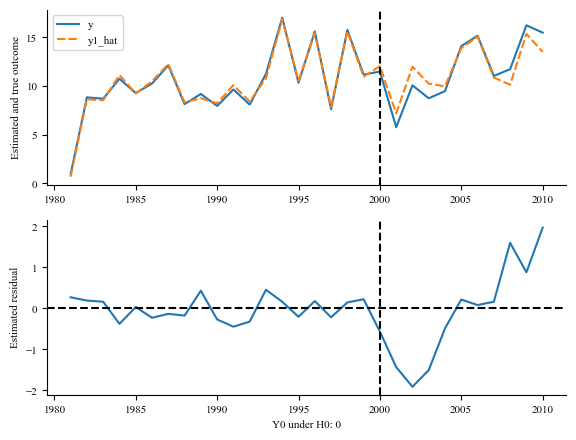

In [160]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))
sns.lineplot(resid[['y', 'y1_hat']], ax=ax[0])

sns.lineplot(resid['residual'], ax=ax[1])
ax[1].axhline(y=0, linestyle='--', color='black')
ax[0].set(ylabel='Estimated and true outcome', xlabel='')
ax[1].set(ylabel='Estimated residual', xlabel='Y0 under H0: 0')

for i in range(2):
    ax[i].axvline(x=resid.query("post_period==0").index[-1], linestyle='--', color='black')
sns.despine()

### 5. Test statistic


$$
S(\hat{u}) = S_q(\hat{u}) = \left( \frac{1}{\sqrt{T_*}} \sum_{t=T_0+1}^{T} |\hat{u}_t|^q \right)^{1/q}.
$$
+ Note that S is constructed such that high values indicate rejection. 

+ If the intervention has a large but only temporary effect, choose $ q= \infty $. 

+ If the inter- vention has a permanent effect, tests using S1 or S2 exhibit good power properties.

In [161]:
# define a function to compute test statistic
def test_statistic(u_hat, q=1, axis=0):
    return (np.abs(u_hat) ** q).mean(axis=axis) ** (1/q)

In [162]:
print("H0:0 ", test_statistic(resid.query("post_period==1")["residual"]))

H0:0  1.025552012282269


### 6. P value

`P-values`

+ We use block permutations to compute p-values. There are two approches:

1. The set of all permutations, which we call iid permutations, $\Pi_{all}$

2. The set of all (overlapping) moving block permutations, $\Pi_{\rightarrow}$

+ The choice of $\Pi$ does not matter for the exact finite sample validity of our procedures if the residuals are exchangeable.

Definition of p-value

\begin{equation*}
\hat{p} = 1 - \hat{F}(S(\hat{u})), \text{ where } \hat{F}(x) = \frac{1}{|\Pi|} \sum_{\pi \in \Pi} 1\{S(\hat{u}_\pi) < x\}.
\end{equation*}

In [163]:
# build a function to compute p value
def compute_pvalue(y, yhat, window):
    residual = y - yhat
    block_permutations = np.stack([np.roll(residual, permutation, axis=0)[-window:] for permutation in range(len(residual))])

    test_stat = test_statistic(block_permutations, q=1, axis=1)
    p_val = np.mean(test_stat >= test_stat[0])
    return p_val

In [164]:
p_val = compute_pvalue(resid['y'], resid['y1_hat'], window=10)
print("Under the null H0:0, the p value is", p_val)

Under the null H0:0, the p value is 0.03333333333333333


In [165]:
# grid search the p value under different null hypothesis
def pval_grid(df, treated, nulls, K, window):
    # build a dic to store p value
    p_vals = {}
    for null in nulls:
        # assign the null
        null_df = under_null(df, null, treated)

        # prepare the matrix for control units
        Y, X = _prepare_matrix(null_df[null_df['tr_group']==0], covariates)
        # estimate F
        F, _ = update_parameter(Y, X, K, verbose=False)

        # prepare the matrix for treated units
        Y1, X1 = _prepare_matrix(null_df[null_df['tr_group']==1], covariates)
        # estimate Gama
        Gama = estimate_gama(Y1, X1, F)

        # compute synthetic control
        Y_hat = compute_syn(X1, Gama, F).mean(axis=0)

        # compute residual
        Y = null_df[null_df['tr_group']==1].groupby("time").y.mean()
        # compute p value
        p_val = compute_pvalue(Y, Y_hat, window=window)
        p_vals[null] = p_val
    return p_vals

In [166]:
# specify the null hypothesis
nulls = np.linspace(-20, 30, 100)
# grid search the p value under different null hypothesis
p_vals = pval_grid(df, 'treated', nulls, K, window=10)

In [167]:
# convert into dataframe
p_vals = pd.DataFrame(p_vals, index=['all_period']).T
p_vals

,all_period
-20.000000,0.033333
-19.494949,0.033333
-18.989899,0.033333
-18.484848,0.033333
-17.979798,0.033333
...,...
27.979798,0.033333
28.484848,0.033333
28.989899,0.033333
29.494949,0.033333


### 7. Confidence interval

In [168]:
# define a function to compute confidence interval
def confidence_interval(p_vals, alpha=0.05):
    big_p_vals = p_vals[p_vals.values >= alpha]
    return pd.DataFrame({
        f"{int(100-alpha*100)}_ci_lower": big_p_vals.index.min(),
        f"{int(100-alpha*100)}_ci_upper": big_p_vals.index.max()
    }, index=[p_vals.columns[0]])

In [169]:
confidence_interval(p_vals, 0.05)

,95_ci_lower,95_ci_upper
all_period,0.20202,18.888889


### 8. Compute confidence interval period by period

In [170]:
# define a function to compute the confidence interval period by period
def confidence_interval_period(df, period, nulls, alpha):
    # append the targeting period to the pre-treatment period
    df_aug = df[(df['post_period']==0) | (df['time']==period)]
    
    # grid search p values under different null hypothesis
    p_vals = pval_grid(df_aug, 'treated', nulls, K, window=1) # window = 1 for period by period
    # covert into dataframe
    p_vals = pd.DataFrame(p_vals, index=[period]).T

    # compute confidence interval
    ci = confidence_interval(p_vals, alpha=alpha)
    return ci

In [171]:
from joblib import Parallel, delayed

# Define a function for parallel processing
def process_period(t):
    ci = confidence_interval_period(df, t, nulls, 0.05)
    print(f'Evaluating period {t} is done!')
    return ci

# Number of jobs is set to -1 to use all available CPUs
# Change this number if you need to limit CPU usage
n_jobs = -1  # You can adjust this based on your system's capabilities

# Parallel computation
ci_df_parallel = Parallel(n_jobs=n_jobs)(delayed(process_period)(t) for t in range(2001, 2010 + 1))

# Combine the results into a single DataFrame
ci_df = pd.concat(ci_df_parallel, axis=0)

Evaluating period 2008 is done!
Evaluating period 2006 is done!
Evaluating period 2002 is done!
Evaluating period 2005 is done!
Evaluating period 2007 is done!
Evaluating period 2001 is done!
Evaluating period 2004 is done!
Evaluating period 2003 is done!
Evaluating period 2009 is done!
Evaluating period 2010 is done!


In [172]:
from src.CSC_IPCA import CSC_IPCA
model = CSC_IPCA()
model.fit(df, 'id', 'time', 'y', 'treated', covariates, 2, verbose=False)
Y_hat = model.predict()

In [173]:
residual = df.query("tr_group==1").groupby('time').y.mean() - Y_hat.mean(axis=0)
ci_df['est_att'] = residual[-T1:]
ci_df

,95_ci_lower,95_ci_upper,est_att
2001,2.222222,5.252525,3.777770
2002,-1.313131,2.222222,1.517991
2003,1.717172,4.747475,2.858053
2004,2.222222,5.757576,4.282812
2005,4.747475,7.777778,5.866362
2006,2.727273,6.262626,4.201003
2007,4.242424,7.777778,4.801327
2008,7.777778,13.838384,9.916690
2009,5.757576,9.292929,8.397857
2010,7.777778,11.313131,9.806635


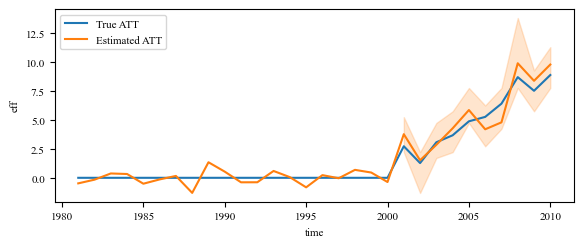

In [175]:
plt.figure(figsize=(6.7, 2.5))

sns.lineplot(df.query("tr_group==1").groupby("time").eff.mean(), label='True ATT')
sns.lineplot(residual, label='Estimated ATT')

yerr = np.abs(ci_df[['95_ci_lower', '95_ci_upper']].subtract(ci_df['est_att'], axis=0)).T.values
plt.fill_between(ci_df.index, ci_df["95_ci_lower"], ci_df["95_ci_upper"], alpha=0.2,  color="C1")
plt.legend(loc='upper left')